In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
PATH = "apple_quality.csv"
dataset = pd.read_csv(PATH)

In [3]:
dataset = dataset.dropna()
dataset = dataset.drop("A_id", axis=1)

In [4]:
for column in dataset:
    if type(dataset[column][0]) is str:
        dataset[column] = pd.factorize(dataset[column])[0]

<Axes: >

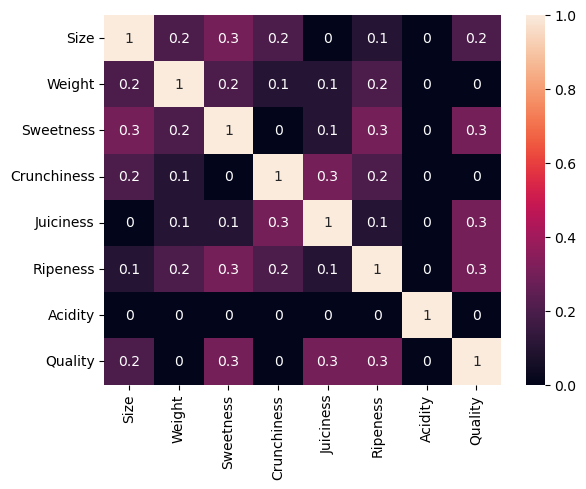

In [5]:
sns.heatmap(
    round(
        abs(dataset.corr()),
        1,
    ),
    annot=True,
)

In [6]:
test_size = 0.2

indices = np.random.permutation(dataset.index)

test_set_size = int(len(dataset) * test_size)
test_indices = indices[:test_set_size]
train_indices = indices[test_set_size:]

train_input = dataset.loc[train_indices].drop("Quality", axis=1).to_numpy()
test_input = dataset.loc[test_indices].drop("Quality", axis=1).to_numpy()
train_output = dataset.loc[train_indices]["Quality"].to_numpy()
test_output = dataset.loc[test_indices]["Quality"].to_numpy()

In [7]:
def calculate_mean(X):
    return np.mean(X, axis=0)

def calculate_covariance(X, mean, epsilon=1e-6):
    m = X.shape[0]
    covariance_matrix = (1 / m) * np.dot((X - mean).T, (X - mean))
    
    covariance_matrix += epsilon * np.eye(covariance_matrix.shape[0])
    
    return covariance_matrix

def multivariate_gaussian_density(x, mean, covariance):
    d = len(mean)
    covariance_det = np.linalg.det(covariance)
    covariance_inv = np.linalg.inv(covariance)
    
    factor = 1 / np.sqrt((2 * np.pi) ** d * abs(covariance_det))
    exponent = -0.5 * np.dot(np.dot((x - mean).T, covariance_inv), (x - mean))
    return factor * np.exp(exponent)

In [8]:
class GaussianNaiveBayesClassifier:
    def __init__(self):
        self.means = {}
        self.covariances = {}
        self.priors = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = calculate_mean(X_cls)
            self.covariances[cls] = calculate_covariance(X_cls, self.means[cls])
            self.priors[cls] = X_cls.shape[0] / X.shape[0]

    def predict(self, X):
        y_pred = [self._predict_single(x) for x in X]
        return np.array(y_pred)

    def _predict_single(self, x):
        posteriors = []

        for cls in self.classes:
            mean = self.means[cls]
            covariance = self.covariances[cls]
            prior = np.log(self.priors[cls])
            
            likelihood = np.log(multivariate_gaussian_density(x, mean, covariance))
            posterior = prior + likelihood
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

In [9]:
model = GaussianNaiveBayesClassifier()
model.fit(train_input, train_output)

In [10]:
predictions = model.predict(test_input)

In [11]:
def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [12]:
accuracy = accuracy_score(test_output, predictions)
print(f"Точность модели на тестовом участке = {accuracy}")

Точность модели на тестовом участке = 0.81375
